In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as st
from scipy.stats import ks_2samp

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')


np.set_printoptions(linewidth=180)

# Plot style (matched to weak/strong figures)
LABEL_FONTSIZE = 14
TICK_LABELSIZE = 14
TITLE_FONTSIZE = 14


def style_axes(ax, xlabel=None, ylabel=None, title=None):
    """Apply consistent font sizes to an axis."""
    if title is not None:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_LABELSIZE)
    return ax

def smoothstep4(t):
    """C^4 smooth step on [0,1] (derivatives up to order 4 vanish at endpoints)."""
    t = np.clip(t, 0.0, 1.0)
    return 126*t**5 - 420*t**6 + 540*t**7 - 315*t**8 + 70*t**9

# Scheme styles (consistent across all plots)
SCHEME_STYLES = {
    'nodal': {'label': 'Nodal (CTMC)', 'color': 'C0'},
    'bin':   {'label': 'Bin-integrated', 'color': 'C1'},
}
SCHEMES = list(SCHEME_STYLES.keys())


def wrap_periodic_1d(x, L):
    # Project to [-L, L) (periodic wrap-around).
    period = 2.0 * L
    return ((np.asarray(x) + L) % period) - L


def periodic_diff_1d(x, y, L):
    # Difference on the circle, returned in [-L, L).
    period = 2.0 * L
    d = np.asarray(x) - np.asarray(y)
    return ((d + L) % period) - L


def periodic_dist_1d(x, y, L):
    return np.abs(periodic_diff_1d(x, y, L))


def periodic_dist_2d(X, Y, L):
    # Euclidean distance on the 2D torus [-L, L)^2 (wrap each coordinate).
    X = np.asarray(X)
    Y = np.asarray(Y)
    dx = periodic_diff_1d(X[..., 0], Y[..., 0], L)
    dy = periodic_diff_1d(X[..., 1], Y[..., 1], L)
    return np.sqrt(dx*dx + dy*dy)


In [2]:
class OU1D:
    """    1D OU process + Markov-chain approximation on [-L, L) with periodic boundary,
    coupled via shared Gaussian increments.

    SDE: dX = -X/tau dt + sig dW
    """
    def __init__(self, dt=0.05, T_max=5.0, tau=1.0, sig=0.05,
                 L=0.1, h=0.01, scheme='nodal', seed=5):
        self.dt    = dt
        self.T_max = T_max
        self.tau   = tau
        self.sig   = sig
        self.L     = float(L)
        self.h     = float(h)
        self.seed  = int(seed)
        self.scheme = scheme

        if scheme == 'nodal':
            self.x_states, Q = self._make_Q1d_nodal()
            self.P1d = linalg.expm(self.dt * Q)
        elif scheme == 'bin':
            self.x_states, self.P1d = self._make_P1d_bin()
        else:
            raise ValueError("scheme must be 'nodal' or 'bin'")

        # Numerical cleanup: enforce a stochastic matrix
        self.P1d = np.maximum(self.P1d, 0.0)
        self.P1d = self.P1d / self.P1d.sum(axis=1, keepdims=True)

        self.cdf1d = np.cumsum(self.P1d, axis=1)

    def _make_uniform_grid(self):
        period = 2.0 * self.L
        N = int(np.round(period / self.h))
        N = max(N, 4)
        h = period / N
        x = -self.L + h * np.arange(N)
        self.h = float(h)
        return x, h

    def _make_Q1d_nodal(self):
        x, h = self._make_uniform_grid()
        tau = self.tau
        sig = self.sig

        diag     = -sig**2 / h**2 + 0 * x
        diag_inf = 0.5 * sig**2 / h**2 + x / (tau * 2 * h)
        diag_sup = 0.5 * sig**2 / h**2 - x / (tau * 2 * h)

        Q = np.diag(diag)
        Q += np.diag(diag_sup[:-1],  1)
        Q += np.diag(diag_inf[1:],  -1)

        # periodic wrap-around
        Q[0, -1] = diag_inf[0]
        Q[-1, 0] = diag_sup[-1]

        return x, Q

    def _make_P1d_bin(self, n_wrap=2):
        """Bin-integrated EM kernel on the periodic domain [-L, L)."""
        x, h = self._make_uniform_grid()

        dt  = self.dt
        tau = self.tau
        sig = self.sig
        period = 2.0 * self.L

        N = x.size

        # Cell edges on one unwrapped period
        edges = (-self.L - 0.5 * h) + h * np.arange(N + 1)

        P = np.zeros((N, N))
        s = sig * np.sqrt(dt)

        shifts = period * np.arange(-n_wrap, n_wrap + 1)
        for i, x0 in enumerate(x):
            m = x0 + dt * (-x0 / tau)
            for sh in shifts:
                z_edges = (edges + sh - m) / s
                cdf_edges = st.norm.cdf(z_edges)
                P[i, :] += cdf_edges[1:] - cdf_edges[:-1]

        P = np.maximum(P, 0.0)
        P = P / P.sum(axis=1, keepdims=True)
        return x, P

    def simulate(self, N_rep=1000, x0=0.0, project_init=True):
        """Simulate N_rep coupled EM/MCA paths on the periodic domain."""
        np.random.seed(self.seed)

        N_T = int(self.T_max / self.dt) + 1
        T = np.arange(N_T) * self.dt

        X_sde = np.zeros((N_rep, N_T))
        X_mc  = np.zeros((N_rep, N_T))

        x0 = float(wrap_periodic_1d(x0, self.L))
        i0 = int(np.argmin(np.abs(self.x_states - x0)))
        if project_init:
            x0 = float(self.x_states[i0])

        X_sde[:, 0] = x0
        ix = np.full(N_rep, i0, dtype=int)
        X_mc[:, 0] = self.x_states[i0]

        for k in range(1, N_T):
            Z = np.random.randn(N_rep)

            # SDE (Euler--Maruyama) on the torus
            X_prev = X_sde[:, k-1]
            X_new  = X_prev + self.dt * (-X_prev / self.tau) + self.sig * np.sqrt(self.dt) * Z
            X_sde[:, k] = wrap_periodic_1d(X_new, self.L)

            # MC (inverse-CDF sampling with common uniforms)
            U = st.norm.cdf(Z)
            for r in range(N_rep):
                cdf = self.cdf1d[ix[r]]
                new_ix = int(np.searchsorted(cdf, U[r], side='left'))
                if new_ix >= cdf.size:
                    new_ix = cdf.size - 1
                ix[r] = new_ix
                X_mc[r, k] = self.x_states[new_ix]

        return T, X_sde, X_mc


def plot_coupled_paths_1d(T, X_sde, X_mc, x_states=None, title=None):
    """1D quick sanity plot: one SDE path vs one MC path (coupled)."""
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.plot(T, X_sde, '-o', ms=2, label='SDE (EM)')
    ax.plot(T, X_mc,  '-o', ms=2, label='MCA')

    if x_states is not None:
        for x in x_states:
            ax.axhline(x, alpha=0.10, lw=0.5, color='k')

    style_axes(ax, xlabel=r'$t$', ylabel=r'$x$', title=title)
    ax.legend()
    fig.tight_layout()
    return fig, ax


def plot_coupled_paths_2d(X_sde, X_mc, x_states, L, title_left=None, title_right=None):
    """2D quick sanity plot: SDE path and coupled SDE/MC paths."""
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(X_sde[:, 0], X_sde[:, 1], '-o', ms=2, label='SDE (EM)')
    ax.plot(X_mc[:, 0],  X_mc[:, 1],  '-o', ms=2, label='MCA')
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect('equal', 'box')

    for x in x_states:
        ax.axhline(x, alpha=0.10, lw=0.5, color='k')
        ax.axvline(x, alpha=0.10, lw=0.5, color='k')

    style_axes(ax, xlabel='x', ylabel='y', title=title_right)
    ax.legend()

    fig.tight_layout()
    return fig, ax


class OU2D:
    """    2D OU process + MCA on [-L, L)^2 with periodic boundary,
    coupled via shared Gaussian increments.

    SDE:
      dX = -X/tau dt + sig dW_x
      dY = -Y/tau dt + sig dW_y
    """
    def __init__(self, dt=0.05, T_max=5.0, tau=1.0, sig=0.05,
                 L=0.1, h=0.01, scheme='nodal', seed=5):
        self.dt    = dt
        self.T_max = T_max
        self.tau   = tau
        self.sig   = sig
        self.L     = float(L)
        self.h     = float(h)
        self.seed  = int(seed)
        self.scheme = scheme

        if scheme == 'nodal':
            self.x_states, Q1d = self._make_Q1d_nodal()
            self.P1d = linalg.expm(self.dt * Q1d)
        elif scheme == 'bin':
            self.x_states, self.P1d = self._make_P1d_bin()
        else:
            raise ValueError("scheme must be 'nodal' or 'bin'")

        self.P1d = np.maximum(self.P1d, 0.0)
        self.P1d = self.P1d / self.P1d.sum(axis=1, keepdims=True)

        self.cdf1d = np.cumsum(self.P1d, axis=1)

        # 2D grid (for plotting only)
        Xg, Yg = np.meshgrid(self.x_states, self.x_states, indexing='ij')
        self.Xg = Xg.ravel()
        self.Yg = Yg.ravel()

    def _make_uniform_grid(self):
        period = 2.0 * self.L
        N = int(np.round(period / self.h))
        N = max(N, 4)
        h = period / N
        x = -self.L + h * np.arange(N)
        self.h = float(h)
        return x, h

    def _make_Q1d_nodal(self):
        x, h = self._make_uniform_grid()
        tau = self.tau
        sig = self.sig

        diag     = -sig**2 / h**2 + 0 * x
        diag_inf = 0.5 * sig**2 / h**2 + x / (tau * 2 * h)
        diag_sup = 0.5 * sig**2 / h**2 - x / (tau * 2 * h)

        Q = np.diag(diag)
        Q += np.diag(diag_sup[:-1],  1)
        Q += np.diag(diag_inf[1:],  -1)

        # periodic wrap-around
        Q[0, -1] = diag_inf[0]
        Q[-1, 0] = diag_sup[-1]

        return x, Q

    def _make_P1d_bin(self, n_wrap=2):
        """Bin-integrated EM kernel on the periodic domain [-L, L)."""
        x, h = self._make_uniform_grid()

        dt  = self.dt
        tau = self.tau
        sig = self.sig
        period = 2.0 * self.L

        N = x.size
        edges = (-self.L - 0.5 * h) + h * np.arange(N + 1)

        P = np.zeros((N, N))
        s = sig * np.sqrt(dt)

        shifts = period * np.arange(-n_wrap, n_wrap + 1)
        for i, x0 in enumerate(x):
            m = x0 + dt * (-x0 / tau)
            for sh in shifts:
                z_edges = (edges + sh - m) / s
                cdf_edges = st.norm.cdf(z_edges)
                P[i, :] += cdf_edges[1:] - cdf_edges[:-1]

        P = np.maximum(P, 0.0)
        P = P / P.sum(axis=1, keepdims=True)
        return x, P

    def simulate(self, N_rep=1000, x0=0.0, y0=0.0, project_init=True):
        """Simulate N_rep coupled EM/MCA paths on the 2D torus."""
        np.random.seed(self.seed)

        N_T = int(self.T_max / self.dt) + 1

        X_sde = np.zeros((N_rep, N_T, 2))
        X_mc  = np.zeros((N_rep, N_T, 2))

        x0 = float(wrap_periodic_1d(x0, self.L))
        y0 = float(wrap_periodic_1d(y0, self.L))

        i0 = int(np.argmin(np.abs(self.x_states - x0)))
        j0 = int(np.argmin(np.abs(self.x_states - y0)))
        if project_init:
            x0 = float(self.x_states[i0])
            y0 = float(self.x_states[j0])

        X_sde[:, 0, 0] = x0
        X_sde[:, 0, 1] = y0

        ix = np.full(N_rep, i0, dtype=int)
        iy = np.full(N_rep, j0, dtype=int)
        X_mc[:, 0, 0] = self.x_states[i0]
        X_mc[:, 0, 1] = self.x_states[j0]

        for k in range(1, N_T):
            Z = np.random.randn(N_rep, 2)

            # SDE (Euler--Maruyama) on the torus
            X_prev = X_sde[:, k-1, :]
            dW     = np.sqrt(self.dt) * Z
            X_new  = X_prev + self.dt * (-X_prev / self.tau) + self.sig * dW
            X_sde[:, k, :] = wrap_periodic_1d(X_new, self.L)

            # MC (product of 1D kernels, coupled via common uniforms)
            U = st.norm.cdf(Z)
            for r in range(N_rep):
                u_x, u_y = U[r, 0], U[r, 1]

                cdf_x = self.cdf1d[ix[r]]
                new_ix = int(np.searchsorted(cdf_x, u_x, side='left'))
                if new_ix >= cdf_x.size:
                    new_ix = cdf_x.size - 1

                cdf_y = self.cdf1d[iy[r]]
                new_iy = int(np.searchsorted(cdf_y, u_y, side='left'))
                if new_iy >= cdf_y.size:
                    new_iy = cdf_y.size - 1

                ix[r] = new_ix
                iy[r] = new_iy
                X_mc[r, k, 0] = self.x_states[new_ix]
                X_mc[r, k, 1] = self.x_states[new_iy]

        T = np.arange(N_T) * self.dt
        return T, X_sde, X_mc


def indicator_ball(x, center=(0.0, 0.0), radius=0.1):
    """
    x : array (N, 2)
    retourne un booléen (N,) pour 1_{|x-center| <= radius}
    """
    dx = x[:, 0] - center[0]
    dy = x[:, 1] - center[1]
    return dx*dx + dy*dy <= radius*radius


def smooth_indicator_ball(x, center=(0.0, 0.0), radius=0.1, eps=0.02):
    """C^4 compactly-supported approximation of 1_{|x-center| <= radius} with transition width eps."""
    dx = x[:, 0] - center[0]
    dy = x[:, 1] - center[1]
    r = np.sqrt(dx*dx + dy*dy)

    y = np.zeros_like(r, dtype=float)
    inside = r <= radius
    trans = (radius < r) & (r < radius + eps)

    y[inside] = 1.0
    y[trans] = smoothstep4((radius + eps - r[trans]) / eps)
    return y

def prob_in_set_for_init(h,
                         x0, y0,
                         set_indicator,      # indicatrice (bool) ou version lisse [0,1]
                         N_rep=5000,
                         T_max=1.0,
                         dt=0.01,
                         tau=1.0,
                         sig=0.05,
                         L=0.3,
                         scheme='nodal',
                         seed=0,
                         smooth=False):
    """Return coupled weak estimators for one initial condition (2D).

    Returns (P_EM, P_MC, diff_mean, diff_hw_95) where:
      - P_EM = E[phi(X_T^{EM})]
      - P_MC = E[phi(X_T^{MCA})]
      - diff_mean = P_EM - P_MC (paired estimator)
      - diff_hw_95 is an (approx.) 95% half-width for diff_mean (CLT).

    set_indicator may return booleans (indicator) or floats in [0,1].
    EM and MCA are simulated with the same Gaussian increments (variance reduction).
    """
    sim = OU2D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    _, X_sde, X_mc = sim.simulate(N_rep=N_rep, x0=x0, y0=y0)

    final_sde = X_sde[:, -1, :]  # (N_rep, 2)
    final_mc  = X_mc[:, -1, :]

    # Absorption : NaN => en dehors de l'ensemble
    alive_sde = ~np.isnan(final_sde[:, 0])
    alive_mc  = ~np.isnan(final_mc[:, 0])

    phi_sde = np.zeros(N_rep, dtype=float)
    phi_mc  = np.zeros(N_rep, dtype=float)

    phi_sde[alive_sde] = np.asarray(set_indicator(final_sde[alive_sde]), dtype=float)
    phi_mc[alive_mc]   = np.asarray(set_indicator(final_mc[alive_mc]), dtype=float)

    diff = phi_sde - phi_mc
    diff_mean = float(diff.mean())
    diff_se = float(diff.std(ddof=1) / np.sqrt(diff.size))
    diff_hw_95 = 1.96 * diff_se

    return float(phi_sde.mean()), float(phi_mc.mean()), diff_mean, diff_hw_95

def weak_error_sup_over_inits(h,
                              init_grid,     # liste/array de (x0,y0)
                              set_indicator,
                              N_rep=5000,
                              smooth=False,
                              **kwargs):
    """Compute weak set-probability error over a grid of initial conditions (2D).

    Returns:
      - max_err  = max_{(x0,y0)} |P_EM - P_MC|
      - errors   = array of |P_EM - P_MC| for each init
      - (lo, hi) = an (approx.) 95% CI envelope for max_err

    The CI is built from paired CLT intervals for each init, then taking
    max over inits (envelope).
    """
    errors = []
    lows = []
    highs = []

    for (x0, y0) in init_grid:
        P_EM, P_MC, diff_mean, diff_hw_95 = prob_in_set_for_init(
            h, x0, y0, set_indicator, N_rep=N_rep, smooth=smooth, **kwargs
        )
        err = abs(diff_mean)
        lo = max(0.0, err - diff_hw_95)
        hi = err + diff_hw_95
        errors.append(err)
        lows.append(lo)
        highs.append(hi)

    max_err = float(np.max(errors))
    max_lo = float(np.max(lows))
    max_hi = float(np.max(highs))
    return max_err, np.asarray(errors), (max_lo, max_hi)

def indicator_interval(x, a=-0.1, b=0.1):
    x = np.asarray(x)
    return (a <= x) & (x <= b)


def smooth_indicator_interval(x, a=-0.1, b=0.1, eps=0.02):
    """C^4 compactly-supported approximation of 1_{[a,b]} with transition width eps."""
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)

    left = (a - eps < x) & (x < a)
    inside = (a <= x) & (x <= b)
    right = (b < x) & (x < b + eps)

    y[left] = smoothstep4((x[left] - (a - eps)) / eps)
    y[inside] = 1.0
    y[right] = smoothstep4(((b + eps) - x[right]) / eps)
    return y


def prob_in_set_for_init_1d(h,
                            x0,
                            set_indicator,
                            N_rep=5000,
                            smooth=False,
                            T_max=1.0,
                            dt=0.01,
                            tau=1.0,
                            sig=0.05,
                            L=0.3,
                            scheme='nodal',
                            seed=0):
    """Return coupled weak estimators for one initial condition (1D).

    Returns (P_EM, P_MC, diff_mean, diff_hw_95) where:
      - P_EM = E[phi(X_T^{EM})]
      - P_MC = E[phi(X_T^{MCA})]
      - diff_mean = P_EM - P_MC (paired estimator)
      - diff_hw_95 is an (approx.) 95% half-width for diff_mean (CLT).

    set_indicator may return booleans (indicator) or floats in [0,1].
    EM and MCA are simulated with the same Gaussian increments (variance reduction).
    """
    sim = OU1D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    _, X_sde, X_mc = sim.simulate(N_rep=N_rep, x0=x0)

    final_sde = X_sde[:, -1]
    final_mc = X_mc[:, -1]

    alive_sde = ~np.isnan(final_sde)
    alive_mc = ~np.isnan(final_mc)

    # set_indicator may return a boolean indicator or float weights in [0,1].
    # We always compute E[phi(X_T)]; for an indicator this equals a probability.
    phi_sde = np.zeros(N_rep, dtype=float)
    phi_mc = np.zeros(N_rep, dtype=float)

    phi_sde[alive_sde] = np.asarray(set_indicator(final_sde[alive_sde]), dtype=float)
    phi_mc[alive_mc] = np.asarray(set_indicator(final_mc[alive_mc]), dtype=float)

    diff = phi_sde - phi_mc
    diff_mean = float(diff.mean())
    diff_se = float(diff.std(ddof=1) / np.sqrt(diff.size))
    diff_hw_95 = 1.96 * diff_se

    return float(phi_sde.mean()), float(phi_mc.mean()), diff_mean, diff_hw_95

def weak_error_sup_over_inits_1d(h,
                                init_grid,
                                set_indicator,
                                N_rep=5000,
                                smooth=False,
                                **kwargs):
    """Compute weak set-probability error over a grid of initial conditions (1D).

    Returns:
      - max_err  = max_{x0} |P_EM - P_MC|
      - errors   = array of |P_EM - P_MC| for each init
      - (lo, hi) = an (approx.) 95% CI envelope for max_err

    The CI is built from paired CLT intervals for each init, then taking
    max over inits (envelope).
    """
    errors = []
    lows = []
    highs = []

    for x0 in init_grid:
        P_EM, P_MC, diff_mean, diff_hw_95 = prob_in_set_for_init_1d(
            h, x0, set_indicator, N_rep=N_rep, smooth=smooth, **kwargs
        )
        err = abs(diff_mean)
        lo = max(0.0, err - diff_hw_95)
        hi = err + diff_hw_95
        errors.append(err)
        lows.append(lo)
        highs.append(hi)

    max_err = float(np.max(errors))
    max_lo = float(np.max(lows))
    max_hi = float(np.max(highs))
    return max_err, np.asarray(errors), (max_lo, max_hi)

def strong_error_rms_timegrid_1d(h,
                                N_rep=2000,
                                T_max=1.0,
                                dt=0.01,
                                tau=1.0,
                                sig=0.05,
                                L=0.3,
                                scheme='nodal',
                                seed=0,
                                x0=0.0):
    """RMS strong error on the time grid (1D).

    Returns (mean, lo, hi) where mean = max_m (E dist(EM, MCA)^2)^{1/2}
    and (lo, hi) is an approximate 95% envelope CI.
    """
    sim = OU1D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    _, X_sde, X_mc = sim.simulate(N_rep=N_rep, x0=x0, project_init=True)

    d = periodic_dist_1d(X_sde, X_mc, L)
    d2 = d**2

    mean_t = d2.mean(axis=0)
    se_t = d2.std(axis=0, ddof=1) / np.sqrt(d2.shape[0])
    hw_t = 1.96 * se_t

    lo_t = np.maximum(mean_t - hw_t, 0.0)
    hi_t = mean_t + hw_t

    sq_est = float(mean_t.max())
    sq_lo = float(lo_t.max())
    sq_hi = float(hi_t.max())
    return float(np.sqrt(sq_est)), float(np.sqrt(sq_lo)), float(np.sqrt(sq_hi))


def strong_error_rms_timegrid_2d(h,
                                N_rep=2000,
                                T_max=1.0,
                                dt=0.01,
                                tau=1.0,
                                sig=0.05,
                                L=0.3,
                                scheme='nodal',
                                seed=0,
                                x0=0.0,
                                y0=0.0):
    """RMS strong error on the time grid (2D torus).

    Returns (mean, lo, hi) where mean = max_m (E dist(EM, MCA)^2)^{1/2}
    and (lo, hi) is an approximate 95% envelope CI.
    """
    sim = OU2D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    _, X_sde, X_mc = sim.simulate(N_rep=N_rep, x0=x0, y0=y0, project_init=True)

    d = periodic_dist_2d(X_sde, X_mc, L)
    d2 = d**2

    mean_t = d2.mean(axis=0)
    se_t = d2.std(axis=0, ddof=1) / np.sqrt(d2.shape[0])
    hw_t = 1.96 * se_t

    lo_t = np.maximum(mean_t - hw_t, 0.0)
    hi_t = mean_t + hw_t

    sq_est = float(mean_t.max())
    sq_lo = float(lo_t.max())
    sq_hi = float(hi_t.max())
    return float(np.sqrt(sq_est)), float(np.sqrt(sq_lo)), float(np.sqrt(sq_hi))


# ------------------------------------------------------------------
# Multi-scheme plotting helpers
# ------------------------------------------------------------------

from matplotlib.lines import Line2D


def plot_paths_1d(T, X_sde_1d, mc_1d_by_scheme, x_states, scheme_styles, title=None, show_legend=False):
    """1D: one EM path + both MCA schemes, with CTMC spatial grid shown."""
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(T, X_sde_1d, color='k', lw=1.5, alpha=0.9, label='SDE (EM)')
    for scheme, X_mc in mc_1d_by_scheme.items():
        st = scheme_styles[scheme]
        ax.plot(T, X_mc, color=st['color'], lw=1.5, alpha=0.9, label=st['label'])

    # Show the CTMC grid as minor grid lines at the state locations
    ax.set_yticks(x_states, minor=True)
    ax.grid(True, which='both', ls=':', alpha=0.5)

    # Keep axes consistent with the periodic domain
    ax.set_ylim(np.min(x_states), np.max(x_states))

    style_axes(ax, xlabel=r'$t$', ylabel=r'$x$', title=title)

    if show_legend:
        ax.legend(fontsize=TICK_LABELSIZE,
                    handlelength=1, 
                    borderaxespad=0.25,
                    handletextpad=0.4,)

    fig.tight_layout()
    return fig, ax


def plot_paths_2d(X_sde_2d, mc_2d_by_scheme, x_states, L, scheme_styles, title=None, show_legend=True):
    """2D: one EM path + both MCA schemes, with CTMC spatial grid shown."""
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(X_sde_2d[:, 0], X_sde_2d[:, 1], color='k', lw=1.5, alpha=0.9, label='SDE (EM)')
    for scheme, X_mc in mc_2d_by_scheme.items():
        st = scheme_styles[scheme]
        ax.plot(X_mc[:, 0], X_mc[:, 1], color=st['color'], lw=1.5, alpha=0.9, label=st['label'])

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect('equal', 'box')

    # Show the CTMC grid as minor grid lines at the state locations
    ax.set_xticks(x_states, minor=True)
    ax.set_yticks(x_states, minor=True)
    ax.grid(True, which='both', ls=':', alpha=0.5)

    style_axes(ax, xlabel=r'$x$', ylabel=r'$y$', title=title)

    if show_legend:
        ax.legend(fontsize=TICK_LABELSIZE,
                   handlelength=1, 
                    borderaxespad=0.25,
                    handletextpad=0.4,)

    fig.tight_layout()
    return fig, ax


def plot_errors(h_list,
                errors_by_scheme,
                scheme_styles,
                title=None,
                show_legend=False,
                bounds=None,
                bounds_label='Bound',
                bounds_color='0.5',
                ci_alpha=0.18):
    """Weak (dotted) + strong (solid) errors vs h for one dimension.

    - Empirical errors are shown in scheme colors.
    - 95% confidence bands are added via fill_between.
    - Optional bounds are drawn in gray with the same linestyle as the
      corresponding empirical curve (strong: solid, weak: dotted).

    Expected keys in errors_by_scheme[scheme]:
      - 'weak', 'strong'
      - 'weak_ci_low', 'weak_ci_high'
      - 'strong_ci_low', 'strong_ci_high'
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    if bounds is not None:
        if 'strong' in bounds:
            ax.loglog(h_list, bounds['strong'], linestyle='-', color=bounds_color, lw=2)
        if 'weak' in bounds:
            ax.loglog(h_list, bounds['weak'], linestyle=':', color=bounds_color, lw=2)

    for scheme, st in scheme_styles.items():
        yS = np.asarray(errors_by_scheme[scheme]['strong'])
        yW = np.asarray(errors_by_scheme[scheme]['weak'])

        yS_lo = errors_by_scheme[scheme].get('strong_ci_low')
        yS_hi = errors_by_scheme[scheme].get('strong_ci_high')
        if yS_lo is not None and yS_hi is not None:
            yS_lo = np.maximum(np.asarray(yS_lo), 1e-16)
            yS_hi = np.maximum(np.asarray(yS_hi), 1e-16)
            ax.fill_between(h_list, yS_lo, yS_hi, color=st['color'], alpha=ci_alpha, linewidth=0)

        yW_lo = errors_by_scheme[scheme].get('weak_ci_low')
        yW_hi = errors_by_scheme[scheme].get('weak_ci_high')
        if yW_lo is not None and yW_hi is not None:
            yW_lo = np.maximum(np.asarray(yW_lo), 1e-16)
            yW_hi = np.maximum(np.asarray(yW_hi), 1e-16)
            ax.fill_between(h_list, yW_lo, yW_hi, color=st['color'], alpha=ci_alpha, linewidth=0)

        ax.loglog(h_list, yS, linestyle='-', marker='o', color=st['color'])
        ax.loglog(h_list, yW, linestyle=':', marker='o', color=st['color'])

    style_axes(ax, xlabel='h (grid size)', ylabel='Error', title=title)
    ax.grid(True, which='both', ls=':')

    if show_legend:
        scheme_handles = [Line2D([], [], color=st['color'], lw=2, label=st['label'])
                          for st in scheme_styles.values()]
        if bounds is not None:
            scheme_handles.append(Line2D([], [], color=bounds_color, lw=2, label=bounds_label))

        type_handles = [
            Line2D([], [], color='k', lw=2, linestyle='-', label='Strong'),
            Line2D([], [], color='k', lw=2, linestyle=':', label='Weak'),
        ]

        leg1 = ax.legend(handles=scheme_handles, loc='upper left',
                        fontsize=TICK_LABELSIZE,
                        handlelength=1,
                        borderaxespad=0.25,
                        handletextpad=0.4,)
        ax.add_artist(leg1)
        ax.legend(handles=type_handles, loc='lower right',
                fontsize=TICK_LABELSIZE,
                handlelength=1,
                borderaxespad=0.25,
                handletextpad=0.4,)

    fig.tight_layout()
    return fig, ax


In [3]:
# ------------------------------------------------------------------
# Coupled sample paths (export as two separate figures: 1D and 2D)
# ------------------------------------------------------------------

dt    = 0.05
T_max = 10.0

tau   = 1.0
sig   = 0.5

L     = 1.2
h     = 0.1

seed  = 2
x0_1d = 0.0
x0_2d = 0.0
y0_2d = 0.0

# 1D: simulate both schemes (shared randomness via same seed)
mc_1d_by_scheme = {}
for scheme in SCHEMES:
    sim = OU1D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    T_1d, X_sde_1d, X_mc_1d = sim.simulate(N_rep=1, x0=x0_1d)
    mc_1d_by_scheme[scheme] = X_mc_1d[0]

# CTMC grid (same for both schemes)
x_states = sim.x_states

# 2D: simulate both schemes (shared randomness via same seed)
mc_2d_by_scheme = {}
for scheme in SCHEMES:
    sim2 = OU2D(dt=dt, T_max=T_max, tau=tau, sig=sig, L=L, h=h, scheme=scheme, seed=seed)
    T_2d, X_sde_2d, X_mc_2d = sim2.simulate(N_rep=1, x0=x0_2d, y0=y0_2d)
    mc_2d_by_scheme[scheme] = X_mc_2d[0]


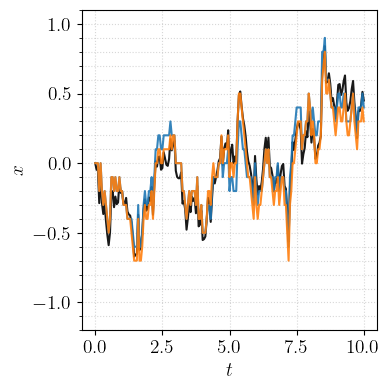

In [4]:
# Plot: 1D coupled path (no legend; the 2D plot carries the legend)

fig, ax = plot_paths_1d(
    T_1d,
    X_sde_1d[0],
    mc_1d_by_scheme,
    x_states=x_states,
    scheme_styles=SCHEME_STYLES,
    title=None,
    show_legend=False,
)
plt.show()


In [5]:
# fig.savefig('figs/paths-1d.pdf', format='pdf', bbox_inches='tight')  # (optional) export

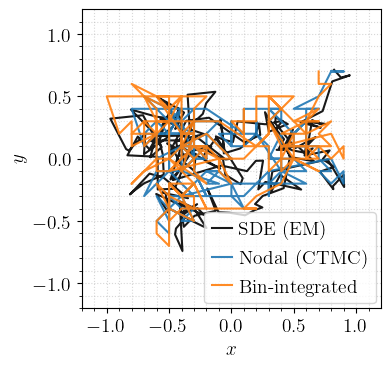

In [6]:
# Plot: 2D coupled path (legend shown once)

fig, ax = plot_paths_2d(
    X_sde_2d[0],
    mc_2d_by_scheme,
    x_states=x_states,
    L=L,
    scheme_styles=SCHEME_STYLES,
    title=None,
    show_legend=True,
)
plt.show()


In [ ]:
# fig.savefig('figs/paths-2d.pdf', format='pdf', bbox_inches='tight')  # (optional) export

: 

In [ ]:
# ------------------------------------------------------------------
# Weak + strong errors vs h (export as two separate figures: 1D and 2D)
#   - strong: solid line
#   - weak:   dotted line
#   - color:  scheme (consistent with the path plots)
#   - bounds: gray (same linestyle as empirical)
#   - CI:     95% bands via fill_between
#
# Notes:
#   - Weak error is a target-set probability error (indicator payoff).
#   - The weak bound uses the smoothing parameter eps and is minimized over eps
#     for each h (trade-off: discretization vs boundary layer).
#   - The strong bound constant is minimized over theta (trade-off in the
#     (a+b)^2 inequality), and we use the OU contraction for the drift.
# ------------------------------------------------------------------

# Shared parameters
T_max = 1.0
dt    = 0.01
tau   = 1.0
sig   = 0.05
L     = 0.3

# Use a periodic grid: enforce h = (2L)/N for integer N
period = 2.0 * L
h_targets = np.logspace(-4, -2, 8)
N_list = np.unique(np.maximum(8, np.round(period / h_targets).astype(int)))
h_list = np.sort(period / N_list)

# Monte Carlo budgets (adjust as needed)
N_rep_weak   = 5000
N_rep_strong = 2000

seed_weak   = 1
seed_strong = 2

# Target sets (true indicators)
int_a, int_b = -0.1, 0.1
eps = 0.02
set_indicator_1d = lambda x: indicator_interval(x, a=int_a, b=int_b)
set_indicator_1d = lambda x: smooth_indicator_interval(x, a=int_a, b=int_b, eps=eps)

ball_center = (0.0, 0.0)
ball_radius = 0.1
set_indicator_2d = lambda x: indicator_ball(x, center=ball_center, radius=ball_radius)
set_indicator_2d = lambda x: smooth_indicator_ball(x, center=ball_center, radius=ball_radius, eps=eps)


# Initial-condition grids for the sup_{x0} weak error
x0_vals = np.linspace(-0.1, 0.1, 3)
init_grid_1d = list(x0_vals)

y0_vals = np.linspace(-0.1, 0.1, 3)
init_grid_2d = [(x0, y0) for x0 in x0_vals for y0 in y0_vals]


# Containers
errors_1d = {
    scheme: {
        'weak': [], 'weak_ci_low': [], 'weak_ci_high': [],
        'strong': [], 'strong_ci_low': [], 'strong_ci_high': [],
    }
    for scheme in SCHEMES
}
errors_2d = {
    scheme: {
        'weak': [], 'weak_ci_low': [], 'weak_ci_high': [],
        'strong': [], 'strong_ci_low': [], 'strong_ci_high': [],
    }
    for scheme in SCHEMES
}

for h in h_list:
    print(f"h = {h:.4g}")
    for scheme in SCHEMES:
        # Weak errors + 95% CI (paired estimator)
        w1d, _, (w1d_lo, w1d_hi) = weak_error_sup_over_inits_1d(
            h,
            init_grid_1d,
            set_indicator_1d,
            N_rep=N_rep_weak,
            smooth=False,
            T_max=T_max,
            dt=dt,
            tau=tau,
            sig=sig,
            L=L,
            scheme=scheme,
            seed=seed_weak,
        )
        w2d, _, (w2d_lo, w2d_hi) = weak_error_sup_over_inits(
            h,
            init_grid_2d,
            set_indicator_2d,
            N_rep=N_rep_weak,
            smooth=False,
            T_max=T_max,
            dt=dt,
            tau=tau,
            sig=sig,
            L=L,
            scheme=scheme,
            seed=seed_weak,
        )

        errors_1d[scheme]['weak'].append(w1d)
        errors_1d[scheme]['weak_ci_low'].append(w1d_lo)
        errors_1d[scheme]['weak_ci_high'].append(w1d_hi)

        errors_2d[scheme]['weak'].append(w2d)
        errors_2d[scheme]['weak_ci_low'].append(w2d_lo)
        errors_2d[scheme]['weak_ci_high'].append(w2d_hi)

        # Strong errors + 95% CI (time-grid RMS metric)
        s1d, s1d_lo, s1d_hi = strong_error_rms_timegrid_1d(
            h,
            N_rep=N_rep_strong,
            T_max=T_max,
            dt=dt,
            tau=tau,
            sig=sig,
            L=L,
            scheme=scheme,
            seed=seed_strong,
            x0=0.0,
        )
        s2d, s2d_lo, s2d_hi = strong_error_rms_timegrid_2d(
            h,
            N_rep=N_rep_strong,
            T_max=T_max,
            dt=dt,
            tau=tau,
            sig=sig,
            L=L,
            scheme=scheme,
            seed=seed_strong,
            x0=0.0,
            y0=0.0,
        )

        errors_1d[scheme]['strong'].append(s1d)
        errors_1d[scheme]['strong_ci_low'].append(s1d_lo)
        errors_1d[scheme]['strong_ci_high'].append(s1d_hi)

        errors_2d[scheme]['strong'].append(s2d)
        errors_2d[scheme]['strong_ci_low'].append(s2d_lo)
        errors_2d[scheme]['strong_ci_high'].append(s2d_hi)

# Convert to numpy arrays
for errs in (errors_1d, errors_2d):
    for scheme in SCHEMES:
        for k in errs[scheme].keys():
            errs[scheme][k] = np.asarray(errs[scheme][k], dtype=float)


# ------------------------------------------------------------------
# Theoretical bounds (from the draft; OU parameters plugged in)
# ------------------------------------------------------------------

# smoothstep4'(t), smoothstep4''(t) sup norms on [0,1]
t = np.linspace(0.0, 1.0, 20001)
ss1 = 630*t**4 - 2520*t**5 + 3780*t**6 - 2520*t**7 + 630*t**8
ss2 = 2520*t**3 - 12600*t**4 + 22680*t**5 - 17640*t**6 + 5040*t**7
SS1_INF = float(np.max(np.abs(ss1)))
SS2_INF = float(np.max(np.abs(ss2)))

# EM one-step Gaussian density bounds (1D/2D)
s = sig * np.sqrt(dt)

rho1_sup = 1.0 / (s * np.sqrt(2.0 * np.pi))
rho1_prime_sup = 1.0 / (s**2 * np.sqrt(2.0 * np.pi * np.e))

rho2_sup = 1.0 / (2.0 * np.pi * s**2)
rho2_grad_sup = 1.0 / (2.0 * np.pi * np.sqrt(np.e) * s**3)

# Time-grid length
M = int(np.round(T_max / dt))

# OU Euler coefficient
alpha_ou = 1.0 - dt / tau

# Sums of |alpha_ou|^k that appear in ||u'|| and ||u''|| bounds
pow1 = np.abs(alpha_ou) ** np.arange(M - 1, -1, -1)   # alpha^{M-(m+1)}
sum1 = float(pow1.sum())
sum2 = float((pow1**2).sum())

# Weak (bin) smooth-payoff constants (coarse but explicit)
#   C_bin(f_eps) = c1 * ||f'||_inf + c2 * ||f''||_inf
cw1_c1 = (period / 12.0) * rho1_prime_sup * sum1
cw1_c2 = (period / 24.0) * rho1_sup * sum2

area = period**2
cw2_c1 = (area / 6.0) * np.sqrt(2.0) * rho2_grad_sup * sum1
cw2_c2 = (area / 12.0) * rho2_sup * sum2

# Density bound at time T for the boundary-layer term (periodized Gaussian)
# Unwrapped EM law: N(mean, var_T) with var_T = sig^2 * dt * sum_{j=0}^{M-1} alpha^{2j}
if abs(alpha_ou) < 1.0:
    var_T = (sig**2) * dt * (1.0 - alpha_ou**(2 * M)) / (1.0 - alpha_ou**2)
else:
    var_T = (sig**2) * T_max

K_wrap = 8
k = np.arange(-K_wrap, K_wrap + 1)
S_wrap = float(np.sum(np.exp(-((2.0 * k * L)**2) / (2.0 * var_T))))

M_T_1d = (1.0 / np.sqrt(2.0 * np.pi * var_T)) * S_wrap
M_T_2d = (1.0 / (2.0 * np.pi * var_T)) * (S_wrap**2)

# --- Weak bound: optimize eps for each h ---

# Search range for eps (must be small relative to domain)
eps_min = 1e-4
eps_max = 0.2

eps_grid = np.logspace(np.log10(eps_min), np.log10(eps_max), 600)

# 1D: interval smoothing derivative bounds
f1_prime = SS1_INF / eps_grid
f1_second = SS2_INF / (eps_grid**2)
C_smooth_1d = cw1_c1 * f1_prime + cw1_c2 * f1_second
B_layer_1d = M_T_1d * (2.0 * eps_grid)  # |∂_eps [a,b]| = 2 eps

weak_bound_1d = []
weak_eps_opt_1d = []
for h in h_list:
    total = (h**2) * C_smooth_1d #+ B_layer_1d
    j = int(np.argmin(total))
    weak_bound_1d.append(float(total[j]))
    weak_eps_opt_1d.append(float(eps_grid[j]))
weak_bound_1d = np.asarray(weak_bound_1d)

# 2D: ball smoothing derivative bounds (radial construction)
# ||grad f||_inf ~ SS1/eps
# ||Hess f||_inf has two contributions: radial curvature and second derivative
f2_grad = SS1_INF / eps_grid
f2_hess = np.maximum(SS2_INF / (eps_grid**2), SS1_INF / (eps_grid * ball_radius))
C_smooth_2d = cw2_c1 * f2_grad + cw2_c2 * f2_hess

B_layer_2d = M_T_2d * (np.pi * (2.0 * ball_radius * eps_grid + eps_grid**2))

weak_bound_2d = []
weak_eps_opt_2d = []
for h in h_list:
    total = (h**2) * C_smooth_2d #+ B_layer_2d
    j = int(np.argmin(total))
    weak_bound_2d.append(float(total[j]))
    weak_eps_opt_2d.append(float(eps_grid[j]))
weak_bound_2d = np.asarray(weak_bound_2d)

print('Weak bound eps*(1D):', weak_eps_opt_1d)
print('Weak bound eps*(2D):', weak_eps_opt_2d)

# --- Strong bound: optimize theta (OU contraction) ---

# For OU with constant sigma, the EM mismatch term contracts exactly:
# D_{m+1} = |(1 - dt/tau) delta_m|, so a_delta = (1 - dt/tau)^2.
a_delta_strong = (1.0 - dt / tau) ** 2

log_theta = np.linspace(-8.0, 3.0, 2000)
theta_grid = np.exp(log_theta)

Ctheta = np.empty_like(theta_grid)
for i, theta in enumerate(theta_grid):
    a = (1.0 + theta) * a_delta_strong
    b = (1.0 + 1.0 / theta) / 4.0

    if abs(a - 1.0) < 1e-12:
        Ctheta[i] = 0.25 + b * M
    else:
        aM = a ** M
        Ctheta[i] = aM / 4.0 + b * (aM - 1.0) / (a - 1.0)

j = int(np.argmin(Ctheta))
theta_opt = float(theta_grid[j])
Cstrong_sq_opt = float(Ctheta[j])
Cstrong_rms_opt = float(np.sqrt(Cstrong_sq_opt))

print('Strong bound theta*:', theta_opt)
print('Strong bound C^{1/2}:', Cstrong_rms_opt)

bounds_1d = {
    'weak': weak_bound_1d,
    'strong': Cstrong_rms_opt * h_list,
}

bounds_2d = {
    'weak': weak_bound_2d,
    'strong': np.sqrt(2.0) * Cstrong_rms_opt * h_list,
}


h = 1e-05


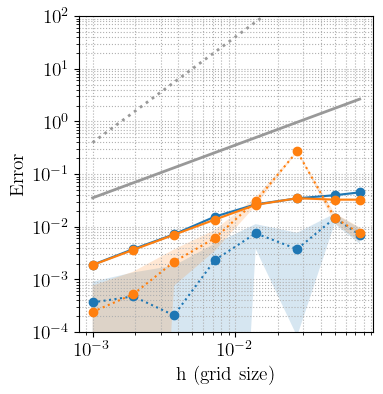

In [40]:
# Plot: 1D errors (no legend; the 2D plot carries the legend)

fig, ax = plot_errors(
    h_list,
    errors_1d,
    scheme_styles=SCHEME_STYLES,
    title=None,
    show_legend=False,
    bounds=bounds_1d,
    bounds_label='Bound',
    bounds_color='0.6',
)
ax.set_ylim(1e-4,1e2)
plt.show()


In [41]:
# fig.savefig('figs/errors-1d.pdf', format='pdf', bbox_inches='tight')  # (optional) export

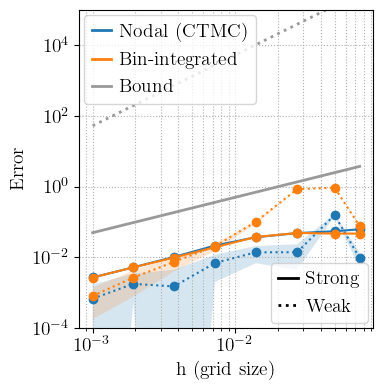

In [42]:
# Plot: 2D errors (legend shown once)

fig, ax = plot_errors(
    h_list,
    errors_2d,
    scheme_styles=SCHEME_STYLES,
    title=None,
    show_legend=True,
    bounds=bounds_2d,
    bounds_label='Bound',
    bounds_color='0.6',
)
ax.set_ylim(1e-4,1e5)

plt.show()


In [ ]:
# fig.savefig('figs/errors-2d.pdf', format='pdf', bbox_inches='tight')  # (optional) export